## Description
In this notebook, we study the basics of the housing market in SD, including distribution of properties, transactions and price over different geographic areas(eg zip), time and other characteristic brackets.

### property & transaction distribution
* property distribution
  * property per city/zip
  * property construction over years
* transaction distribution in last year 2017
  * transaction volume per zip
  * turnover rate per zip 
  * transaction volume per price bracket 
  * transaction volume per sqft bracket 

### yearly transaction trend
* transaction volume trend over years
* transaction sqft_price(price per sqft) trend over years
* last year transaction sqft_price trend over months. More research on seasonality will be done in a separate notebook.

### yearly sqft_price trend
* median sqft_price trend per zip
* median sqft_price trend per sqft_bracket

In [1]:
%load_ext autoreload
%autoreload 1
import os,sys
import numpy as np
import pandas as pd

src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport algorithm
from algorithm import *

import logging
from utils import *
set_logger(logging.WARNING)

### load data

In [2]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_address_schools')
print(df_transaction.shape)
print(df_property.shape)

pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features = list(set(use_features ) - set(school_features))
df_all = pp.dataset(feature='all')

(1477830, 37)
(710576, 34)


In [3]:
df_1year = pp.dataset(feature='all', date=('2016-10-01', '2017-10-01'))
df_1year['sold_month'] = df_1year['date'].dt.month
df_1year.shape

(40520, 40)

In [4]:
df_all_valid = pp.dataset(feature='all', valid=True)
df_all_valid.shape

(1372199, 40)

### property distributions
* over city/zip
* New construction over years. Note: 'year_built' is missing for properties that were constructed during 2000~2017. (119826 out of 602266 missing)

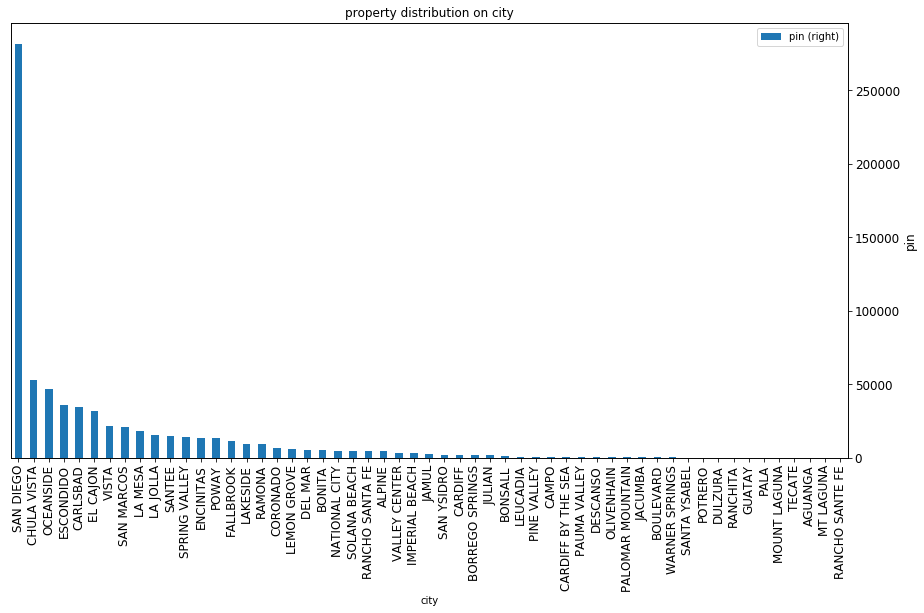

In [5]:
# distribution of all properties over city
prop_dist_on_city = df_property.groupby(by=['city']).count().sort_values(by='pin', ascending=False)
plot_histogram(prop_dist_on_city, None, 'pin', title='property distribution on city')

valid year_built(1918, 2000): (581048, 34)


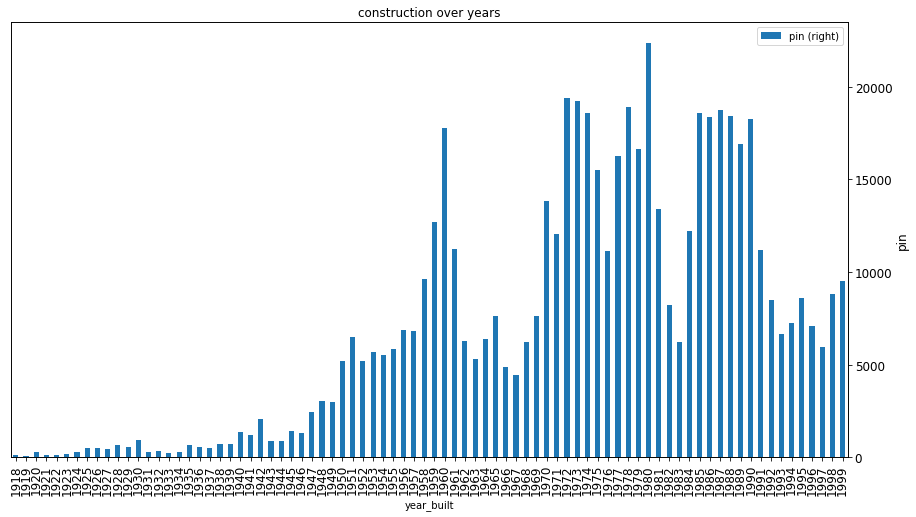

In [6]:
# distribution of construction
print("valid year_built(1918, 2000):",df_property[(df_property['year_built'] >= 1918) & (df_property['year_built'] <= 2000)].shape)
prop_dist_on_year = df_property[(df_property['year_built'] >= 1918) & (df_property['year_built'] <= 2000)].groupby(by=['year_built']).count()
prop_dist_on_year.index = prop_dist_on_year.index.astype(int)
plot_histogram(prop_dist_on_year, None, 'pin', title='construction over years')

### transaction distribution
* over time (yearly/monthly)
* over district (zip)
* over price

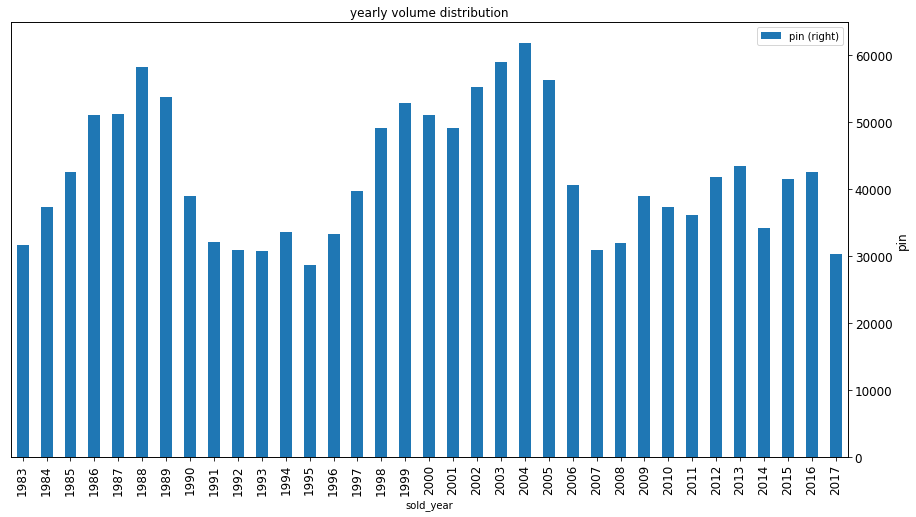

In [22]:
# yearly distribution of transaction
df_over_year = df_all.groupby(by=['sold_year']).count()
plot_histogram(df_over_year, None, 'pin', title='yearly volume distribution')

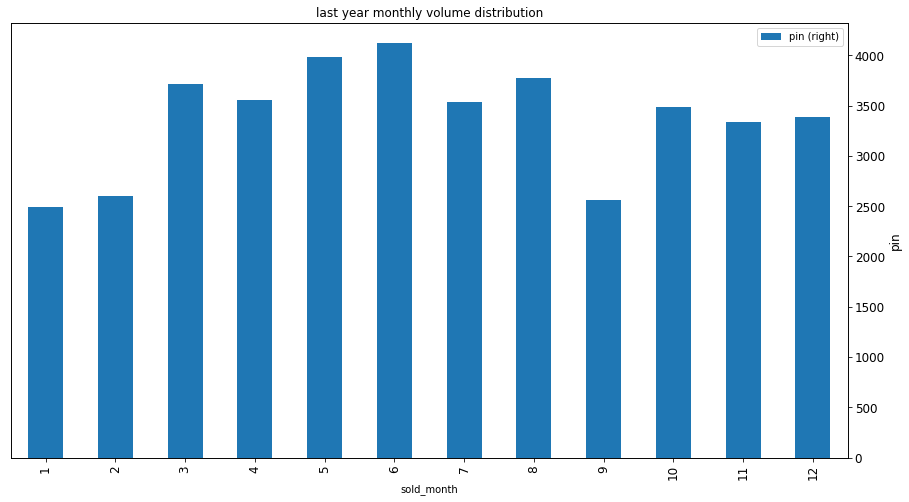

In [23]:
#monthly distribution of last year transaction
df_1year_over_month = df_1year.groupby(['sold_month']).count()
plot_histogram(df_1year_over_month, None, 'pin', title='last year monthly volume distribution')

In [7]:
# zip statistics
trans_1year_on_zip = df_1year.groupby(by=['zip']).count().sort_values(by='pin', ascending=False).pin
prop_dist_on_zip = df_property.groupby(by=['zip']).count().sort_values(by='pin', ascending=False).pin
turnover = trans_1year_on_zip / prop_dist_on_zip

df_zip_stats = pd.DataFrame({'volume':trans_1year_on_zip, 'property_count': prop_dist_on_zip, 'turnover': turnover})
df_zip_stats = df_zip_stats.drop(['90067','91607', '99212'])

volume distribution of last year 2017


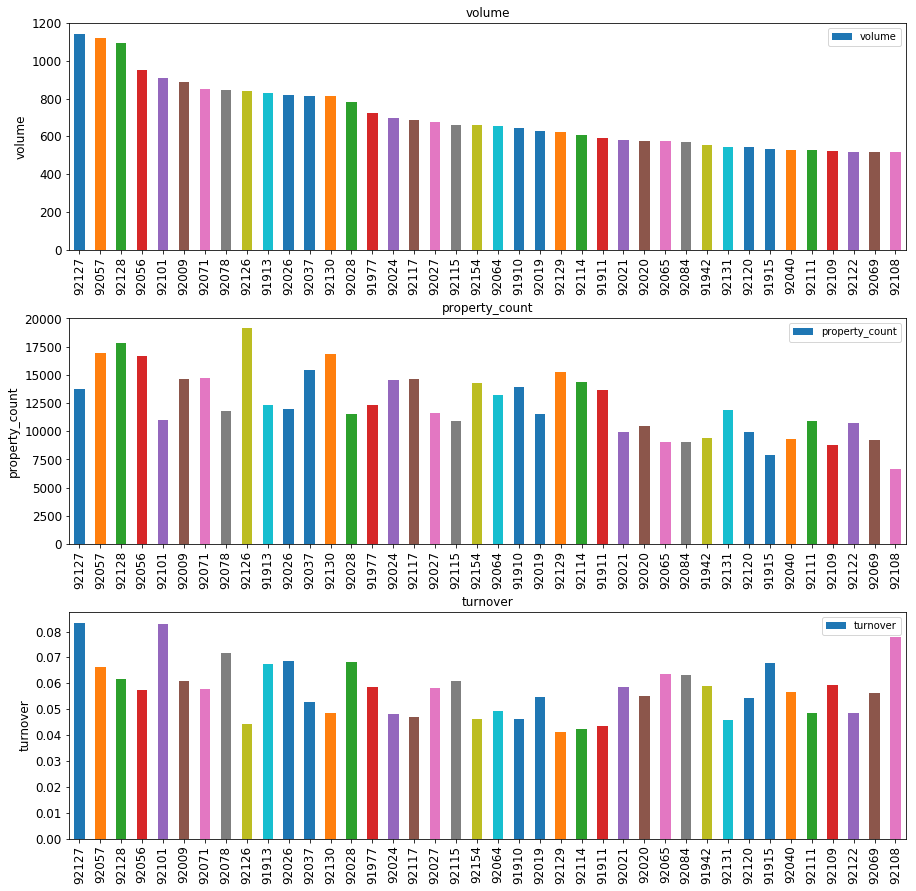

In [21]:
top_zips = df_zip_stats.sort_values(by='volume', ascending=False)[:40]
print('volume distribution of last year 2017')
plot_histogram_group(top_zips, None, ['volume', 'property_count', 'turnover'])

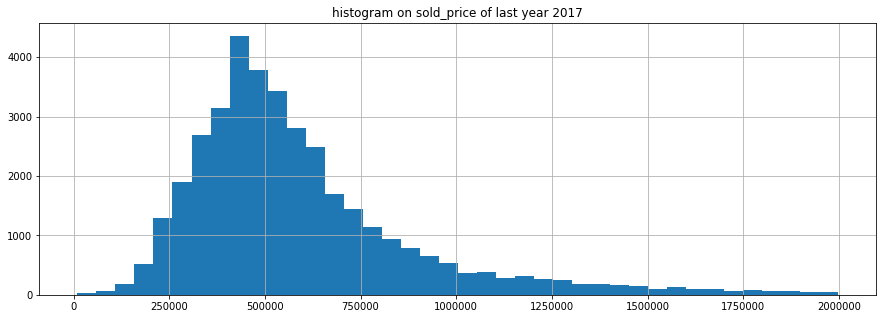

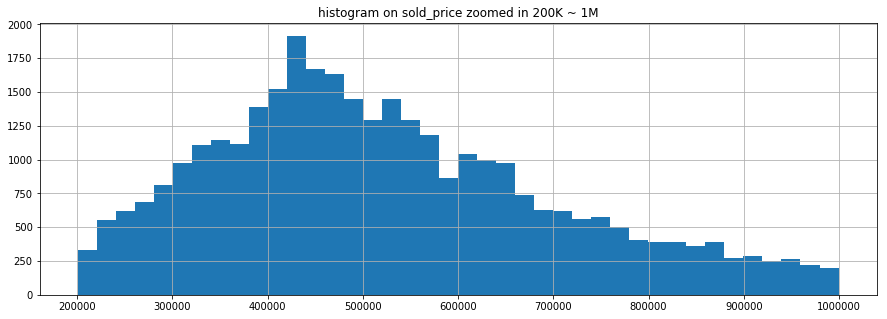

In [40]:
df_1year[(df_1year['sold_price'] > 0) & (df_1year['sold_price'] < 2000000)].hist(column='sold_price', bins=40, figsize=(15, 5))
plt.title('histogram on sold_price of last year 2017')
df_1year[(df_1year['sold_price'] > 200000) & (df_1year['sold_price'] < 1000000)].hist(column='sold_price', bins=40, figsize=(15, 5))
plt.title('histogram on sold_price zoomed in 200K ~ 1M')
plt.show()

### sqft_price
* histogram on sqft_price of last year
* long-term trend: appreciation/depreciation over years
  * aggregated by area (zip)
  * aggregated by price/sqft brackets

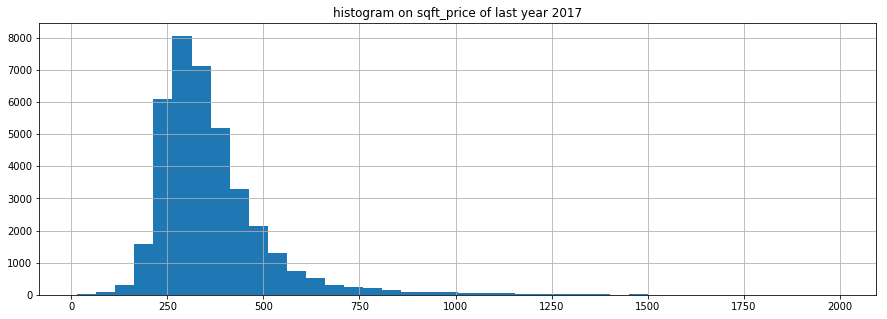

In [48]:
df_1year[(df_1year['sqft_price']>0) & (df_1year['sqft_price']<2000)].hist(column='sqft_price',bins=40, figsize=(15, 5))
plt.title('histogram on sqft_price of last year 2017')
plt.show()

In [31]:
df_unit_price_trend = df_all_valid[(df_all_valid['sqft_price']<1000)]

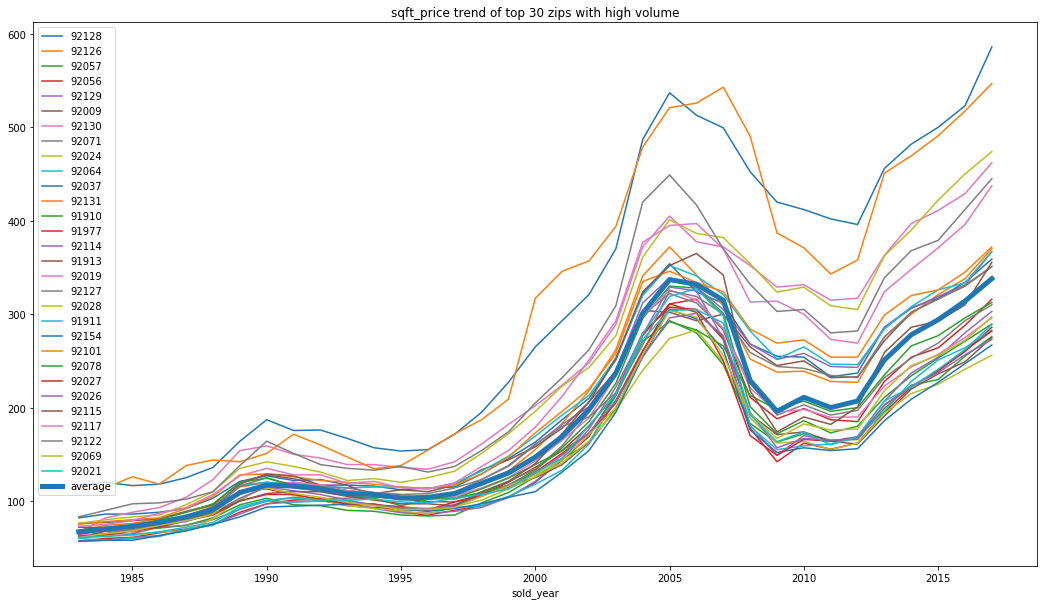

In [55]:
# aggregated by zip
zip_counts = df_all_valid['zip'].value_counts()

df_zip_sqft_price_trend = df_all_valid.groupby(by=['zip','sold_year'])['sqft_price'].median()
df_sqft_price_trend = df_all_valid.groupby(by=['sold_year'])['sqft_price'].median()

fig, ax = plt.subplots(figsize=(18,10))
for zip in zip_counts.index[0:30]:
    df_zip_sqft_price_trend[zip].plot(ax=ax, kind='line', label=zip)
df_sqft_price_trend.plot(ax=ax, kind='line', label='average', linewidth=5)
plt.legend(loc='best')
plt.title("sqft_price trend of top 30 zips with high volume")
plt.show()

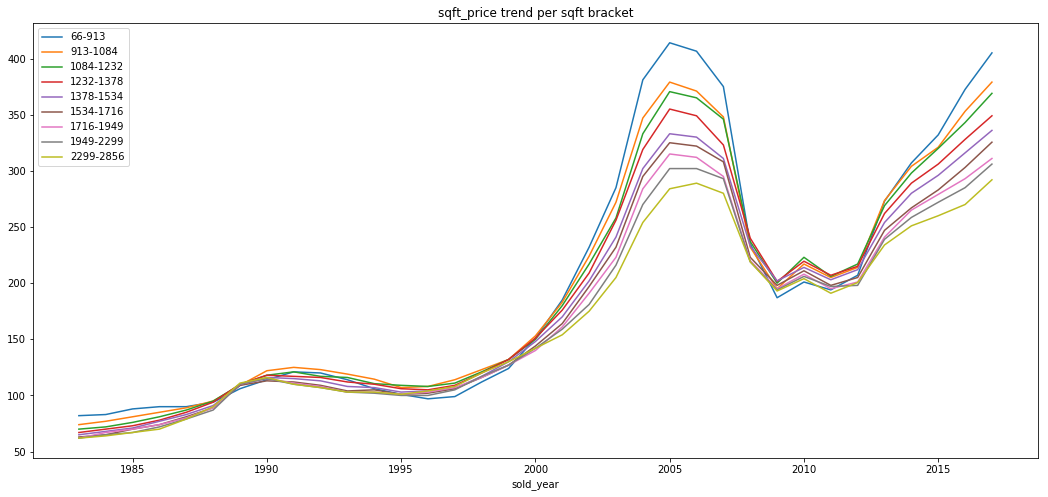

In [62]:
# segmented by sqft range
sqft_brackets = [int(df_all_valid['sqft'].quantile(0.1*i)) for i in range(10)]

fig, ax = plt.subplots(figsize=(18,8))
for i in range(len(sqft_brackets)-1):
    sqft_b,sqft_e = sqft_brackets[i], sqft_brackets[i+1]
    df_sqft_seg = df_all_valid[(df_all_valid['sqft']>=sqft_b) & (df_all_valid['sqft']<sqft_e)]
    #print(df_sqft_seg.shape)
    df_sqft_seg = df_sqft_seg.groupby(by=['sold_year'])['sqft_price'].median()
    df_sqft_seg.plot(ax=ax, kind='line', label="{}-{}".format(sqft_b,sqft_e))
plt.legend(loc='best')
plt.title("sqft_price trend per sqft bracket")
plt.show()
